In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [3]:
workingDirectory = '/home/h1bennet/strains_rna/results/WL02_Strains_AMLNtoControl_WholeLiver_RNA/'
amlnDirectory = '/home/h1bennet/strains/data/RNA/AMLN_21week_wholeliver/'
controlDirectory = '/home/h1bennet/strains/data/RNA/control_wholeliver/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Run Oyoung's pipeline to process RNA-seq data consistantly.

In [4]:
c57_control_paths = list(np.sort(glob.glob(controlDirectory+'/NCoRWT*')))
balbc_control_paths = list(np.sort(glob.glob(controlDirectory+'/balb*')))
aj_control_paths = list(np.sort(glob.glob(controlDirectory+'/aj*')))

c57_control_ids = [i.split('/')[-1].split('_')[4] for i in c57_control_paths]
balbc_control_ids = [i.split('/')[-1].split('_')[4] for i in balbc_control_paths]
aj_control_ids = [i.split('/')[-1].split('_')[4] for i in aj_control_paths]

In [5]:
c57_amln_paths = list(np.sort(glob.glob(amlnDirectory+'/NCoRWT*')))
balbc_amln_paths = list(np.sort(glob.glob(amlnDirectory+'/balb*')))
aj_amln_paths = list(np.sort(glob.glob(amlnDirectory+'/aj*')))

c57_amln_ids = [i.split('/')[-1].split('_')[5] for i in c57_amln_paths]
balbc_amln_ids = [i.split('/')[-1].split('_')[5] for i in balbc_amln_paths]
aj_amln_ids = [i.split('/')[-1].split('_')[5] for i in aj_amln_paths]

Put together into three separate comparisons

In [6]:
ids = ['c57_wholeliver_control_young',
       'c57_wholeliver_amlndiet_30weeks',
       'balbc_wholeliver_control_young',
       'balbc_wholeliver_amlndiet_30weeks',
       'aj_wholeliver_control_young',
       'aj_wholeliver_amlndiet_30weeks']

colors = ['#74c476',
          '#006d2c',
          '#6baed6',
          '#08519c',
          '#de2d26',
          '#a50f15']

paths = [';'.join(c57_control_paths),
         ';'.join(c57_amln_paths),
         ';'.join(balbc_control_paths),
         ';'.join(balbc_amln_paths),
         ';'.join(aj_control_paths),
         ';'.join(aj_amln_paths)]

short_ids = [';'.join([ids[0]+'_'+i for i in c57_control_ids]),
             ';'.join([ids[1]+'_'+i for i in c57_amln_ids]),
             ';'.join([ids[0]+'_'+i for i in balbc_control_ids]),
             ';'.join([ids[1]+'_'+i for i in balbc_amln_ids]),
             ';'.join([ids[0]+'_'+i for i in aj_control_ids]),
             ';'.join([ids[1]+'_'+i for i in aj_amln_ids])]

pd.DataFrame([ids,colors,paths,short_ids]).T.to_csv('./sampleDef.txt',
                                                    sep='\t',
                                                    header=False,
                                                    index=False)

# Run O'young RNA pipeline

Run the code below in BASH.
Edited for this pipeline to lower the minimum TPM threshold as this has kind of messed up our differential gene calling for borderline genes that do not meet the TPM in two of the strains ie TPM > 8 in one strain and TPM of 7 in the other two.

    source activate r-ouyangPipe
    
    mkdir ./expression/
    
    mkdir ./differential/
    
    rnaQuan.R ./sampleDef.txt -o ./expression/

    rnaDiff.R ./sampleDef.txt -c ./expression/rawC.txt \
    -t ./expression/rawT.txt -m 12 -o ./differential/
    
    rm ./differential/c57*aj*
    rm ./differential/c57*balbc*
    rm ./differential/balbc*aj*
    rm ./differential/balbc*c57*
    rm ./differential/aj*c57*
    rm ./differential/aj*balbc*

    # annotate scatter files with tag counts
    for scatter in ./differential/*scatter.txt;
    do diff2Homer.R -d $scatter -q ./expression/HOMER.rawTPM.txt;
    done

### Make sure to check the PCA pdf file for outliers

## Make jupyter hub for vizualization

    makeMultiWigHub.pl hrb_strains_viz_wholeliver_rna_amln_control_merged mm10 \
    -color 251,106,74 165,15,21 107,174,214 8,81,156 116,196,118 0,109,44 \
    -d ./expression/mergeTag/aj_wholeliver_control_young/ \
    ./expression/mergeTag/aj_wholeliver_amlndiet_30weeks/ \
    ./expression/mergeTag/balbc_wholeliver_control_young \
    ./expression/mergeTag/balbc_wholeliver_amlndiet_30weeks \
    ./expression/mergeTag/c57_wholeliver_control_young \
    ./expression/mergeTag/c57_wholeliver_amlndiet_30weeks

# Import differential gene files for examination and plotting

Make folder for figures

In [7]:
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')

## Write differential genes to list for metascape

In [8]:
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')

In [12]:
log2fc = np.log2(1.5)
pval = 0.05
gene_list_dict ={}

In [13]:
for i in np.sort(glob.glob('./differential/*homer.txt')):
    print(i)
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes = df.index[(df['padj'] < pval) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('.')[3]+'_up'] = list(sig_genes)
    # print('union set length:', print(len(g_union)))
    # print('intersection set length:', print(len(g_intersect)))


./differential/aj_wholeliver_amlndiet_30weeks.vs.aj_wholeliver_control_young.scatter.homer.txt
ge all transcripts (24940, 24)
Diff Gene selected transcripts (4435, 14)
ge selected transcripts (4435, 24)
./differential/aj_wholeliver_control_young.vs.aj_wholeliver_amlndiet_30weeks.scatter.homer.txt
ge all transcripts (24940, 24)
Diff Gene selected transcripts (4435, 14)
ge selected transcripts (4435, 24)
./differential/balbc_wholeliver_amlndiet_30weeks.vs.balbc_wholeliver_control_young.scatter.homer.txt
ge all transcripts (24940, 24)
Diff Gene selected transcripts (4790, 14)
ge selected transcripts (4790, 24)
./differential/balbc_wholeliver_control_young.vs.balbc_wholeliver_amlndiet_30weeks.scatter.homer.txt
ge all transcripts (24940, 24)
Diff Gene selected transcripts (4790, 14)
ge selected transcripts (4790, 24)
./differential/c57_wholeliver_amlndiet_30weeks.vs.c57_wholeliver_control_young.scatter.homer.txt
ge all transcripts (24940, 24)
Diff Gene selected transcripts (4790, 14)
ge sel

In [14]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_wholeliver_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()

aj_wholeliver_control_young_up
63 genes
aj_wholeliver_amlndiet_30weeks_up
136 genes
balbc_wholeliver_control_young_up
33 genes
balbc_wholeliver_amlndiet_30weeks_up
53 genes
c57_wholeliver_control_young_up
183 genes
c57_wholeliver_amlndiet_30weeks_up
298 genes


# How many AMLN induced genes are common

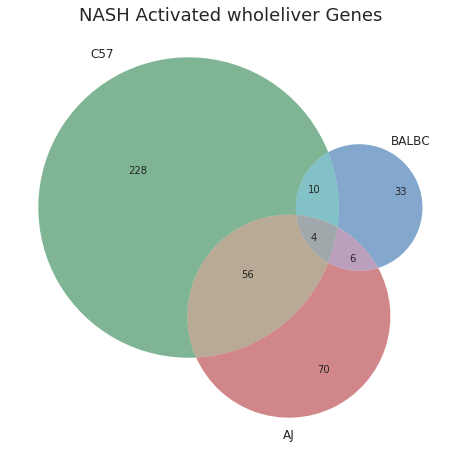

In [15]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(gene_list_dict['c57_wholeliver_amlndiet_30weeks_up']),
               set(gene_list_dict['balbc_wholeliver_amlndiet_30weeks_up']),
               set(gene_list_dict['aj_wholeliver_amlndiet_30weeks_up'])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Activated wholeliver Genes');

plt.savefig('./figures/venn3_activated_genes.png', bbox_inches='tight')

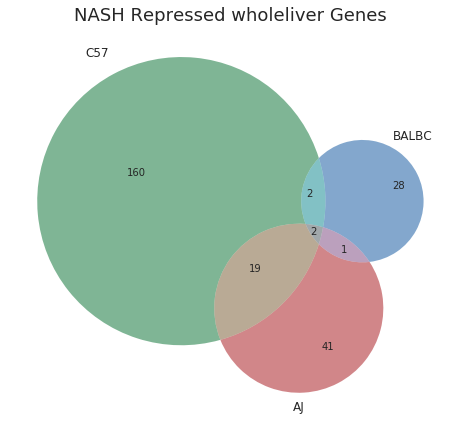

In [16]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn3(subsets=[set(gene_list_dict['c57_wholeliver_control_young_up']),
               set(gene_list_dict['balbc_wholeliver_control_young_up']),
               set(gene_list_dict['aj_wholeliver_control_young_up'])],
     ax=ax,
     set_colors=('#006d2c', '#08519c', '#a50f15'),
     set_labels=('C57', 'BALBC', 'AJ'),
     alpha=0.5)
ax.set_title('NASH Repressed wholeliver Genes');

plt.savefig('./figures/venn3_repressed_genes.png', bbox_inches='tight')

### Pull sets for manual examination

activated genes

In [17]:
all3 = set(gene_list_dict['aj_wholeliver_amlndiet_30weeks_up']).intersection(set(gene_list_dict['balbc_wholeliver_amlndiet_30weeks_up']).intersection(gene_list_dict['c57_wholeliver_amlndiet_30weeks_up']))
C57_balbc = set(gene_list_dict['c57_wholeliver_amlndiet_30weeks_up']).intersection(set(gene_list_dict['balbc_wholeliver_amlndiet_30weeks_up']).difference(all3))
C57_aj = set(gene_list_dict['c57_wholeliver_amlndiet_30weeks_up']).intersection(set(gene_list_dict['aj_wholeliver_amlndiet_30weeks_up']).difference(all3))
balbc_aj = set(gene_list_dict['balbc_wholeliver_amlndiet_30weeks_up']).intersection(gene_list_dict['aj_wholeliver_amlndiet_30weeks_up']).difference(all3)
C57_private = set(gene_list_dict['c57_wholeliver_amlndiet_30weeks_up']).difference(set(all3).union(set(C57_balbc).union(C57_aj)))
balbc_private = set(gene_list_dict['balbc_wholeliver_amlndiet_30weeks_up']).difference(set(all3).union(set(C57_balbc).union(balbc_aj)))
aj_private = set(gene_list_dict['aj_wholeliver_amlndiet_30weeks_up']).difference(set(all3).union(set(C57_aj).union(balbc_aj)))

In [18]:
genesets = [aj_private, balbc_private, C57_private]
genesetnames = ['aj_private', 'balbc_private', 'c57_private']
for listname, genelist in zip(genesetnames, genesets):
    with open('./gene_lists/'+listname+'_wholeliver_genes_fc_'+str(log2fc)+'_pval_'+str(pval)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in genelist:
            f.write(i+'\n')
        f.close()

# Plot potential nichenet ligands

In [19]:
tpm_mat = pd.read_csv('./expression/rawT.txt', sep='\t', index_col=0)

In [20]:
ligands = pd.read_csv('/home/h1bennet/data/gene_lists/nichenet_ligands.txt',
                      sep='\t')['x'].str.capitalize().tolist()
ligands[:5]

['Cxcl1', 'Cxcl2', 'Cxcl3', 'Cxcl5', 'Ppbp']

Collect ALL activated NASH genes

In [21]:
amln_act = []
for key in gene_list_dict.keys():
    if 'amln' in key:
        amln_act.extend(gene_list_dict[key])

amln_act = set(amln_act)

Assess for overlap with ligands

In [22]:
amln_act_ligands = amln_act.intersection(ligands)

## Plot for all samples

In [23]:
tpm_mat.columns

Index(['c57_wholeliver_control_young_c57_wholeliver_control_young_21week',
       'c57_wholeliver_control_young_c57_wholeliver_control_young_21week.1',
       'c57_wholeliver_amlndiet_30weeks_c57_wholeliver_amlndiet_30weeks_LN170A',
       'c57_wholeliver_amlndiet_30weeks_c57_wholeliver_amlndiet_30weeks_LN170B',
       'c57_wholeliver_amlndiet_30weeks_c57_wholeliver_amlndiet_30weeks_LN170C',
       'balbc_wholeliver_control_young_c57_wholeliver_control_young_21week',
       'balbc_wholeliver_control_young_c57_wholeliver_control_young_21week.1',
       'balbc_wholeliver_control_young_c57_wholeliver_control_young_21week.2',
       'balbc_wholeliver_amlndiet_30weeks_c57_wholeliver_amlndiet_30weeks_BALB8A',
       'balbc_wholeliver_amlndiet_30weeks_c57_wholeliver_amlndiet_30weeks_BALB8B',
       'balbc_wholeliver_amlndiet_30weeks_c57_wholeliver_amlndiet_30weeks_BALB8D',
       'aj_wholeliver_control_young_c57_wholeliver_control_young_21week',
       'aj_wholeliver_control_young_c57_wholeli

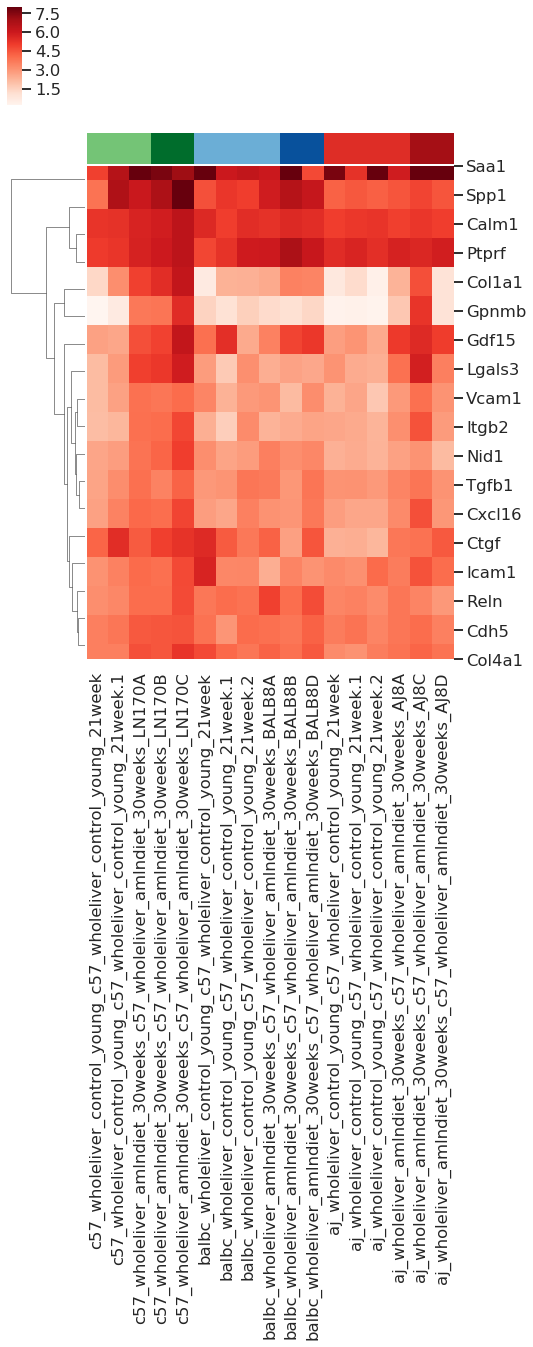

In [28]:
sns.clustermap(
    np.log2(tpm_mat.loc[amln_act_ligands]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    col_colors = ['#74c476', '#74c476', '#74c476',
          '#006d2c', '#006d2c',
          '#6baed6', '#6baed6', '#6baed6', '#6baed6',
          '#08519c', '#08519c',
          '#de2d26', '#de2d26', '#de2d26', '#de2d26',
          '#a50f15', '#a50f15'],
    figsize=(8,12),
    yticklabels=1)

plt.savefig('./figures/diff_genes_ligands_clustermap.png', bbox_inches='tight')
# plt.close()

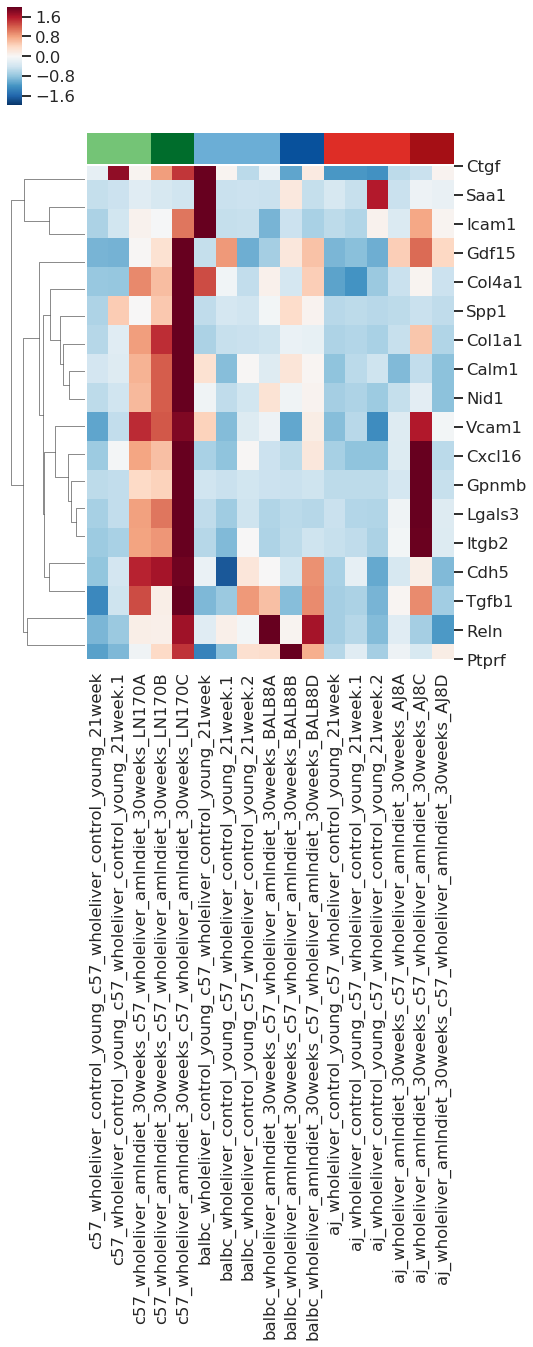

In [29]:
sns.clustermap(
    tpm_mat.loc[amln_act_ligands],
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-2,
    vmax=2,
    col_colors = ['#74c476', '#74c476', '#74c476',
          '#006d2c', '#006d2c',
          '#6baed6', '#6baed6', '#6baed6', '#6baed6',
          '#08519c', '#08519c',
          '#de2d26', '#de2d26', '#de2d26', '#de2d26',
          '#a50f15', '#a50f15'],
    figsize=(8,12),
    yticklabels=1)

plt.savefig('./figures/diff_genes_ligands_clustermap_zscore.png', bbox_inches='tight')
# plt.close()

## Plot Strain Specific Ligands

In [30]:
all_strain_spec = C57_private.union(aj_private).union(balbc_private)
all_strain_spec_ligands = all_strain_spec.intersection(ligands)

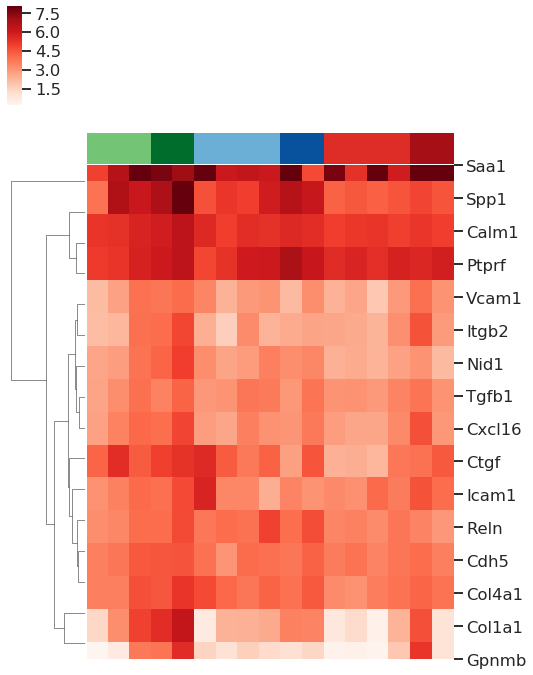

In [31]:
sns.clustermap(
    np.log2(tpm_mat.loc[all_strain_spec_ligands]+1),
    col_cluster=False,
    #z_score=0,
    cmap='Reds',
    #vmin=-2,
    vmax=8,
    col_colors = ['#74c476', '#74c476', '#74c476',
          '#006d2c', '#006d2c',
          '#6baed6', '#6baed6', '#6baed6', '#6baed6',
          '#08519c', '#08519c',
          '#de2d26', '#de2d26', '#de2d26', '#de2d26',
          '#a50f15', '#a50f15'],
    figsize=(8,12),
    yticklabels=1,
    xticklabels=0)

plt.savefig('./figures/diff_genes_strainspecligands_clustermap.png',
            bbox_inches='tight')
# plt.close()

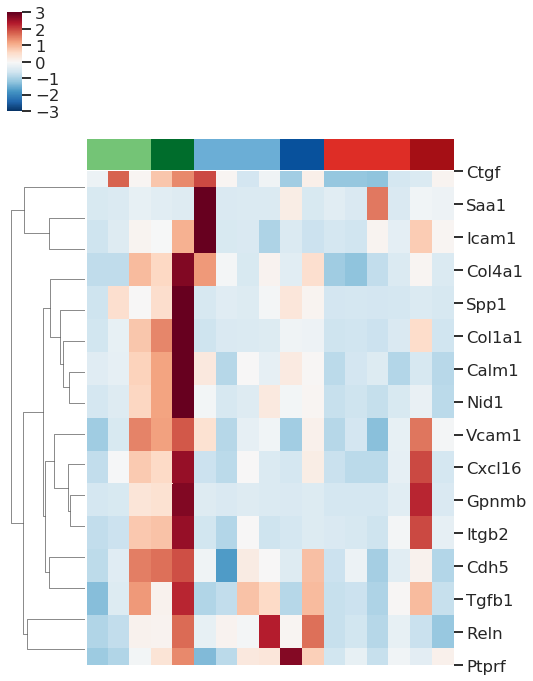

In [32]:
sns.clustermap(
    tpm_mat.loc[all_strain_spec_ligands],
    col_cluster=False,
    z_score=0,
    cmap='RdBu_r',
    vmin=-3,
    vmax=3,
    col_colors = ['#74c476', '#74c476', '#74c476',
          '#006d2c', '#006d2c',
          '#6baed6', '#6baed6', '#6baed6', '#6baed6',
          '#08519c', '#08519c',
          '#de2d26', '#de2d26', '#de2d26', '#de2d26',
          '#a50f15', '#a50f15'],
    figsize=(8,12),
    yticklabels=1,
    xticklabels=0)

plt.savefig('./figures/diff_genes_strainspecligands_clustermap_zscore.png',
            bbox_inches='tight')
# plt.close()

# Plot specific genes as barplots

In [36]:
groups = [[0,1,2,3],
          [4,5],
          [6,7,8,9],
          [10,11],
          [12,13,14,15],
          [16,17]]

group_labels = ['C57BL/6J wholeliver Control young',
                'C57BL/6J wholeliver AMLN 30 weeks',
                'Balb/cJ wholeliver Control young',
                'Balb/cJ wholeliver AMLN 30 weeks',
                'AJ wholeliver Control young',
                'AJ wholeliver AMLN 30 weeks',]

colors = ['#74c476',
          '#006d2c',
          '#6baed6',
          '#08519c',
          '#de2d26',
          '#a50f15']

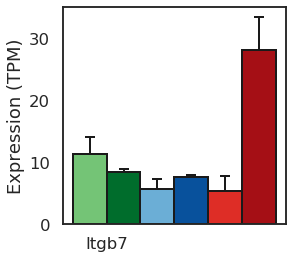

In [85]:
fig, ax = plt.subplots(figsize=(4, 4))

gene_list_bar_plot(['Itgb7'],
                   tpm_mat,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   ax=ax)

ax.get_legend().remove()